In [1]:
%load_ext autoreload
%autoreload 2

In [76]:
from tqdm.notebook import tqdm

import numpy as onp
import matplotlib.pyplot as plt # visualization

import jax
from jax import jit
from jax import grad
import jax.numpy as np
from jax import random
from jax.random import split
from jax.tree_util import tree_multimap

from jax.experimental import optix
from jax.experimental import optimizers
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax # neural network layers

In [37]:
rng = random.PRNGKey(0)
rng

DeviceArray([0, 0], dtype=uint32)

In [64]:
def sample_tasks(outer_batch_size, inner_batch_size, rng):
    # Select amplitude and phase for the task
    rng, rngA, rngP = split(rng, 3)
    As = random.uniform(rngA, shape=(outer_batch_size,), minval=0.1, maxval=.5)
    phases = random.uniform(rngP, shape=(outer_batch_size,), minval=0, maxval=np.pi)
    
    def get_batch(rng):
        xs, ys = [], []
        rngs = split(rng, outer_batch_size)
        for A, phase, rng in zip(As, phases, rngs):
            x = random.uniform(rng, shape=(inner_batch_size, 1), minval=-5., maxval=5., )
            y = A * np.sin(x + phase)
            xs.append(x)
            ys.append(y)
        return np.stack(xs), np.stack(ys)
    rng2, rng3 = split(rng, 2)
    x1, y1 = get_batch(rng2)
    x2, y2 = get_batch(rng3)
    return x1, y1, x2, y2

In [69]:
x1, y1, x2, y2 = sample_tasks(5, 50, rng)

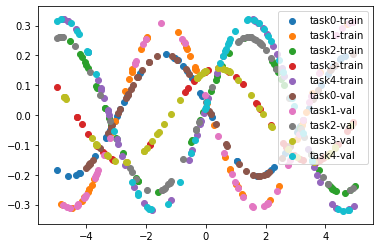

In [70]:
# outer_batch_size = 2
# x1, y1, x2, y2 = sample_tasks(outer_batch_size, 50)
for i in range(x1.shape[0]):
    plt.scatter(x1[i], y1[i], label='task{}-train'.format(i))
for i in range(x1.shape[0]):
    plt.scatter(x2[i], y2[i], label='task{}-val'.format(i))
plt.legend()

In [73]:
net_init, net_apply = stax.serial(
    Dense(40), Relu,
    Dense(40), Relu,
    Dense(1)
)

def make_net(rng, in_shape=(-1, 1)):
    rng, rng_net = split(rng, 2)
    return net_init(rng_net, in_shape)

def mse_loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    return np.mean((targets - predictions) ** 2)

out_shape, net_params = make_net(rng)

In [ ]:
inner_opt_init, inner_opt_update, inner_get_params = optimizers.sgd()

In [80]:
inner_opt = optix.sgd(1e-1)

In [88]:
net_params

[(DeviceArray([[-0.15857112,  0.07812946,  0.3067148 ,  0.11441529,
                 0.02497593, -0.05748412, -0.07522792, -0.34124318,
                -0.11406185,  0.06624709, -0.16856244,  0.4257121 ,
                 0.2899866 , -0.2635129 , -0.11761183, -0.01744621,
                -0.03287956, -0.18570521,  0.04041684, -0.20427641,
                 0.17270212,  0.20348366,  0.23927069,  0.00723149,
                 0.10052092,  0.26869303, -0.08240707, -0.15869519,
                -0.03270275,  0.09788852, -0.08227347,  0.43852043,
                -0.07728187,  0.18920963, -0.13527958, -0.11929529,
                -0.14220762, -0.01560668,  0.04192063, -0.02043647]],            dtype=float32),
  DeviceArray([-0.00106112, -0.00687666, -0.00585964,  0.00148836,
                0.00390003, -0.00650673,  0.01026788,  0.00708069,
                0.00303152,  0.00181245, -0.01017108,  0.00875536,
               -0.00575183, -0.00296836, -0.0025585 , -0.01099165,
               -0.01599

In [91]:
inner_state = inner_opt.init(net_params)
inner_opt.update(net_params, inner_state)

([(DeviceArray([[ 0.01585711, -0.00781295, -0.03067148, -0.01144153,
                 -0.00249759,  0.00574841,  0.00752279,  0.03412432,
                  0.01140619, -0.00662471,  0.01685624, -0.04257121,
                 -0.02899866,  0.02635129,  0.01176118,  0.00174462,
                  0.00328796,  0.01857052, -0.00404168,  0.02042764,
                 -0.01727021, -0.02034837, -0.02392707, -0.00072315,
                 -0.01005209, -0.0268693 ,  0.00824071,  0.01586952,
                  0.00327027, -0.00978885,  0.00822735, -0.04385204,
                  0.00772819, -0.01892096,  0.01352796,  0.01192953,
                  0.01422076,  0.00156067, -0.00419206,  0.00204365]],            dtype=float32),
   DeviceArray([ 0.00010611,  0.00068767,  0.00058596, -0.00014884,
                -0.00039   ,  0.00065067, -0.00102679, -0.00070807,
                -0.00030315, -0.00018124,  0.00101711, -0.00087554,
                 0.00057518,  0.00029684,  0.00025585,  0.00109916,
         

In [82]:
inner_opt.init(net_params)

[TraceState(trace=[(DeviceArray([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32), DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)), (), (DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              ...,
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.],
              [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)), (), (Devic